In [1]:
pip install git+https://github.com/MIROptics/ECC2025.git

  Cloning https://github.com/MIROptics/ECC2025.git to /tmp/pip-req-build-ghv6nfk2
  Running command git clone --filter=blob:none --quiet https://github.com/MIROptics/ECC2025.git /tmp/pip-req-build-ghv6nfk2
  Resolved https://github.com/MIROptics/ECC2025.git to commit 25ba4870a4a815b8ae0c3b7601b4577067e7abfc
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 17.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 12.0

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from scipy.linalg import expm
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp, Operator, process_fidelity
from ECC2025.testing import test_5

La formula de Trotter permite aproximar la evolución de un Hamiltoniano,
$$H = \sum_j H_j $$
mediante un producto de evoluciones rápidas,
$$ U(t) \approx \left(  \prod_j e^{-it H_j/m} \right)^m.$$
La calidad de esta aproximación depende del número de pasos $m$. La formula de Trotter tiene aplicaciones en simulación de materiales, hasta resolución de ecuaciones diferenciales. Para estas aplicaciones es fundamental tener una solución de buena calidad, lo cual puede lograrse aumentando el valor de $m$. Sin embargo, existen otras estrategías que pueden mejorar la calidad sin aumentar los pasos de Trotter. La clave es darse cuenta distintas permutaciones de los operadores $H_j$ dan distintas aproximaciones. Consideremos el siguiente ejemplo
$$ H = X + Y + Z ,$$
donde $\{X,Y,Z\}$ son matrices de Pauli. Las dos siguientes transformaciones son approximaciones válidad de $U=e^{-itH}$ (con $m=1$),
$$ U_1 = e^{-itX}e^{-itY}e^{-itZ},\qquad U_2 = e^{-itZ}e^{-itY}e^{-itX}. $$
Sin embargo, estas aproximaciones no tienen la misma calidad.

In [3]:
H = SparsePauliOp.from_list( [('X',1),('Y',1),('Z',1)] )
def U(t):
    return expm( -1j*H.to_matrix()*t )

t = Parameter('t')
m = 1

In [4]:
qc = QuantumCircuit(1)
for _ in range(m):
    qc.rx( 2*t/m, 0 )
    qc.ry( 2*t/m, 0 )
    qc.rz( 2*t/m, 0 )

U_1 = Operator( qc.assign_parameters([0.2]) )
process_fidelity( U_1, target=Operator(U(0.2)) )

0.9949598835996103

In [5]:
qc = QuantumCircuit(1)
for _ in range(m):
    qc.rz( 2*t/m, 0 )
    qc.ry( 2*t/m, 0 )
    qc.rx( 2*t/m, 0 )

U_2 = Operator( qc.assign_parameters([0.2]) )
process_fidelity( U_2, target=Operator(U(0.2)) )

0.9957866040417919

Podemos ver que $U_1$ tiene una fidelidad del $99.49\%$ y $U_2$ del $99.57\%$, es decir $U_2$ es mejor! Hacer una buena elección en el orden del producto es crucial para alcanzar una buena aproximación en un número alto de qubits.

Consideremos ahora el modelo de Heisenberg, descrito por el siguiente Hamiltoniano
$$H = \sum_{j=0}^{N-2} \left( X_jX_{j+1} + Y_{j}Y_{j+1} + Z_jZ_{j+1} \right) + h\sum_{j=0}^{N-1}Z_j. $$
Este describe la interacción magnética de una cadena de $N$ spíns en presencia de un campo magnético externo $h$. Cada spín es representado por un qubit, siendo $|0\rangle$ el spín arriba y $|1\rangle$ el spín abajo. Cuando todos los spín están alienados decimos que el sistema exhibe magnetización.

![](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC_heisenberg.png?raw=true)

__Desafío:__ Aproxime mediante la formula de Trotter la evolución del modelo de Heisenberg para $N=5$ qubits. Para esto complete el circuito ```Trot_tb_qc``` para que implemente __un paso__ de approximación de Trotter. Su solución debe tener una fidelidad superior al $90\%$ con $m=5$ pasos de Trotter. Por simplicidad considere $h=0$.

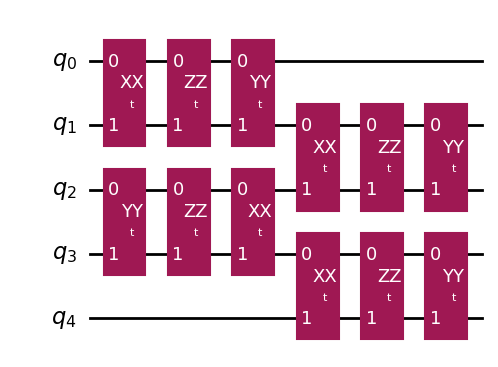

In [56]:
num_qubits = 5

# Definimos el parámetro t
t = Parameter('t')
Trot_tb_qr = QuantumRegister(num_qubits, 'q')
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

# Construimos el circuito ZZ(t)
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

### EDITAR BAJO ESTA LINEA (agregar compuertas)
ZZ_qc.cx(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cx(0,1)
### NO EDITAR BAJO ESTA LINEA

# Convertimos nuestro circuito en una puerta
ZZ = ZZ_qc.to_instruction()

# Construimos la puerta XX(t) a partir de ZZ(t)
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

### EDITAR BAJO ESTA LINEA (agregar compuerta)
XX_qc.h([0,1])

XX_qc.append(ZZ, [0,1])

XX_qc.h([0,1])
### NO EDITAR BAJO ESTA LINEA

# Convertimos nuestro circuito en una puerta
XX = XX_qc.to_instruction()

# Construimos la puerta YY(t) a partir de ZZ(t)
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

### EDITAR BAJO ESTA LINEA (agregar compuertas)
YY_qc.sdg([0,1])
YY_qc.h([0,1])

YY_qc.append(ZZ, [0,1])

YY_qc.h([0,1])
YY_qc.s([0,1])
### NO EDITAR BAJO ESTA LINEA

# Convertir el circuito cuantico en una puerta
YY = YY_qc.to_instruction()

Trot_tb_qc.append(YY, [2,3])
Trot_tb_qc.append(ZZ, [2,3])
Trot_tb_qc.append(XX, [2,3])

Trot_tb_qc.append(XX, [0,1])
Trot_tb_qc.append(ZZ, [0,1])
Trot_tb_qc.append(YY, [0,1])

Trot_tb_qc.append(XX, [1,2])
Trot_tb_qc.append(ZZ, [1,2])
Trot_tb_qc.append(YY, [1,2])

Trot_tb_qc.append(XX, [3,4])
Trot_tb_qc.append(ZZ, [3,4])
Trot_tb_qc.append(YY, [3,4])



### NO EDITAR BAJO ESTA LINEA

################################

Trot_tb_gate = Trot_tb_qc.to_instruction()

Trot_tb_qc.draw('mpl')

In [57]:
def U_trotterize(delta_t, trotter_steps):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    for step in range(trotter_steps):
        qc.append( Trot_tb_gate, list(range(num_qubits)) )

    if qc.num_parameters > 0 :
        qc = qc.assign_parameters({t: delta_t })

    return qc

In [58]:
test_5( U_trotterize )

Fidelidad= 0.9139858131635298
Felicidades, su solución tiene una fidelidad superior al 90%
